In [60]:
import torch
import torch.nn as nn
import pandas as pd 
import numpy as np
from torch.utils.data import TensorDataset,DataLoader
from torch import optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [61]:
df =pd.read_csv("sonar.all-data",header=None)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
108,0.0599,0.0474,0.0498,0.0387,0.1026,0.0773,0.0853,0.0447,0.1094,0.0351,...,0.0013,0.0005,0.0227,0.0209,0.0081,0.0117,0.0114,0.0112,0.0100,M
44,0.0257,0.0447,0.0388,0.0239,0.1315,0.1323,0.1608,0.2145,0.0847,0.0561,...,0.0096,0.0153,0.0096,0.0131,0.0198,0.0025,0.0199,0.0255,0.0180,R
84,0.0378,0.0318,0.0423,0.0350,0.1787,0.1635,0.0887,0.0817,0.1779,0.2053,...,0.0046,0.0044,0.0078,0.0102,0.0065,0.0061,0.0062,0.0043,0.0053,R
62,0.0086,0.0215,0.0242,0.0445,0.0667,0.0771,0.0499,0.0906,0.1229,0.1185,...,0.0072,0.0054,0.0022,0.0016,0.0029,0.0058,0.0050,0.0024,0.0030,R
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R


In [62]:
df.shape

(208, 61)

In [63]:
df[60]=df[60].map({'R':0,'M':1})
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


In [64]:
x=df.drop(60,axis=1)
y=df[60]

In [65]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)

In [66]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [67]:
train_dataset=TensorDataset(x_train_tensor,y_train_tensor)
teat_dataset=TensorDataset(x_test_tensor,y_test_tensor)

In [68]:
train_dataloader=DataLoader(train_dataset,shuffle=True,batch_size=16)
test_dataloader=DataLoader(teat_dataset,shuffle=True,batch_size=16)

In [69]:
class Smiplenn(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(60,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,2)
            
        )
    def forward(self,x):
        return self.network(x)

In [70]:
def train_model(model,train_loader,optimizer,test_loader, criterion,epochs=20):
    train_losses,val_losses,val_accuracies=[],[],[]
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for data , labels in train_loader:
            optimizer.zero_grad()
            pred=model(data)
            loss=criterion(pred,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_losses.append(running_loss/len(train_loader))

        model.eval()
        val_loss=0.0
        y_pred,y_true=[],[]
        with torch.no_grad():
            for data,labels in test_loader:
                pred=model(data)
                loss=criterion(pred,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(pred,axis=1)
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
        val_losses.append(val_loss/len(test_loader))
        val_accuracy=accuracy_score(y_true,y_pred)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch: {epoch+1}/{epochs},Train Loss:{train_losses[-1]:.4f},val_losses:{val_losses[-1]:.4f},val_accuracies:{val_accuracies[-1]:.4f}")
        
    return train_losses,val_losses,val_accuracies

In [71]:
model=Smiplenn()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=0.04) #weight_decay ill define l2 regularization parameter 
criterion=nn.CrossEntropyLoss()
train_losses,val_losses,val_accuracies=train_model(model,train_dataloader,optimizer,test_dataloader,criterion,epochs=30)

Epoch: 1/30,Train Loss:0.6917,val_losses:0.6784,val_accuracies:0.6190
Epoch: 2/30,Train Loss:0.6873,val_losses:0.6709,val_accuracies:0.6190
Epoch: 3/30,Train Loss:0.6855,val_losses:0.6676,val_accuracies:0.6190
Epoch: 4/30,Train Loss:0.6850,val_losses:0.6744,val_accuracies:0.6190
Epoch: 5/30,Train Loss:0.6842,val_losses:0.6697,val_accuracies:0.6190
Epoch: 6/30,Train Loss:0.6848,val_losses:0.6711,val_accuracies:0.6190
Epoch: 7/30,Train Loss:0.6824,val_losses:0.6668,val_accuracies:0.6667
Epoch: 8/30,Train Loss:0.6803,val_losses:0.6650,val_accuracies:0.6667
Epoch: 9/30,Train Loss:0.6798,val_losses:0.6664,val_accuracies:0.7143
Epoch: 10/30,Train Loss:0.6792,val_losses:0.6617,val_accuracies:0.7381
Epoch: 11/30,Train Loss:0.6772,val_losses:0.6659,val_accuracies:0.8095
Epoch: 12/30,Train Loss:0.6759,val_losses:0.6540,val_accuracies:0.7381
Epoch: 13/30,Train Loss:0.6725,val_losses:0.6613,val_accuracies:0.8333
Epoch: 14/30,Train Loss:0.6694,val_losses:0.6439,val_accuracies:0.7381
Epoch: 15/30,Tr

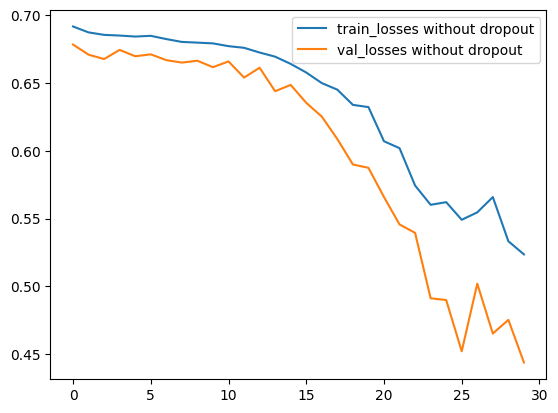

In [72]:
plt.plot(train_losses,label="train_losses without dropout")
plt.plot(val_losses,label="val_losses without dropout")
# plt.plot(val_accuracies,label="val_accuracies without dropout")
plt.legend()
plt.show()

In [73]:
class simplennwithdropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(60,128),
            nn.ReLU(),
            nn.Dropout(p=.5),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=.5),
            nn.Linear(64,2)
        )
    def forward(self,x):
        return self.network(x)

Epoch: 1/30,Train Loss:0.6951,val_losses:0.6834,val_accuracies:0.8095
Epoch: 2/30,Train Loss:0.6952,val_losses:0.6691,val_accuracies:0.6190
Epoch: 3/30,Train Loss:0.6802,val_losses:0.6637,val_accuracies:0.7857
Epoch: 4/30,Train Loss:0.6907,val_losses:0.6504,val_accuracies:0.6905
Epoch: 5/30,Train Loss:0.6638,val_losses:0.6497,val_accuracies:0.8571
Epoch: 6/30,Train Loss:0.6662,val_losses:0.6291,val_accuracies:0.8095
Epoch: 7/30,Train Loss:0.6606,val_losses:0.6240,val_accuracies:0.8571
Epoch: 8/30,Train Loss:0.6425,val_losses:0.5986,val_accuracies:0.8571
stoppage
Epoch: 9/30,Train Loss:0.6345,val_losses:0.5839,val_accuracies:0.8571


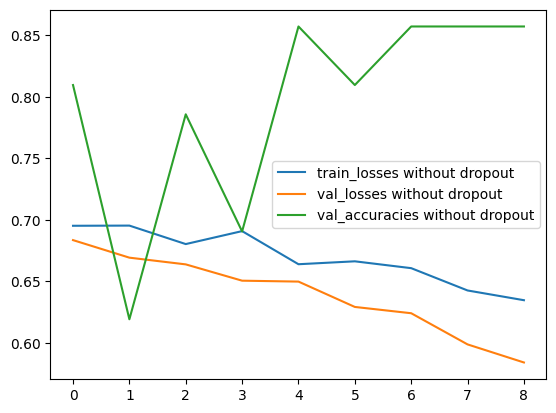

In [86]:
model=simplennwithdropout()
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
train_losses,val_losses,val_accuracies=train_model(model,train_dataloader,optimizer,test_dataloader,criterion,epochs=30)
plt.plot(train_losses,label="train_losses without dropout")
plt.plot(val_losses,label="val_losses without dropout")
plt.plot(val_accuracies,label="val_accuracies without dropout")
plt.legend()
plt.show()

## Early Stoppage

In [87]:
def train_model(model,train_loader,optimizer,test_loader, criterion,epochs=20,thresh=3):
    train_losses,val_losses,val_accuracies=[],[],[]
    count=0
    best_score=0
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for data , labels in train_loader:
            optimizer.zero_grad()
            pred=model(data)
            loss=criterion(pred,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_losses.append(running_loss/len(train_loader))

        model.eval()
        val_loss=0.0
        y_pred,y_true=[],[]
        with torch.no_grad():
            for data,labels in test_loader:
                pred=model(data)
                loss=criterion(pred,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(pred,axis=1)
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
        val_losses.append(val_loss/len(test_loader))
        val_accuracy=accuracy_score(y_true,y_pred)
        val_accuracies.append(val_accuracy)

        if val_accuracy>best_score:
            torch.save(model.state_dict(),'best_model.pt')
            best_score=val_accuracy
            count=0
        else:
            if count==thresh:
                print("stoppage")
                print(f"Epoch: {epoch+1}/{epochs},Train Loss:{train_losses[-1]:.4f},val_losses:{val_losses[-1]:.4f},val_accuracies:{val_accuracies[-1]:.4f}")
                return train_losses,val_losses,val_accuracies
            count+=1
        
         
        print(f"Epoch: {epoch+1}/{epochs},Train Loss:{train_losses[-1]:.4f},val_losses:{val_losses[-1]:.4f},val_accuracies:{val_accuracies[-1]:.4f}")
        
    return train_losses,val_losses,val_accuracies

In [88]:
model=simplennwithdropout()
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
train_losses,val_losses,val_accuracies=train_model(model,train_dataloader,optimizer,test_dataloader,criterion,epochs=30)

Epoch: 1/30,Train Loss:0.7004,val_losses:0.6822,val_accuracies:0.7143
Epoch: 2/30,Train Loss:0.6918,val_losses:0.6805,val_accuracies:0.6667
Epoch: 3/30,Train Loss:0.6844,val_losses:0.6768,val_accuracies:0.7857
Epoch: 4/30,Train Loss:0.6835,val_losses:0.6663,val_accuracies:0.8571
Epoch: 5/30,Train Loss:0.6845,val_losses:0.6644,val_accuracies:0.8095
Epoch: 6/30,Train Loss:0.6643,val_losses:0.6476,val_accuracies:0.8333
Epoch: 7/30,Train Loss:0.6613,val_losses:0.6167,val_accuracies:0.8571
stoppage
Epoch: 8/30,Train Loss:0.6590,val_losses:0.6048,val_accuracies:0.8571


In [89]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [85]:
y_pred,y_true=[],[]
with torch.no_grad():
        for data,labels in test_dataloader:
            pred=model(data)
            loss=criterion(pred,labels)
            _,predicted=torch.max(pred,axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
accuracy_score(y_true,y_pred)

0.8333333333333334

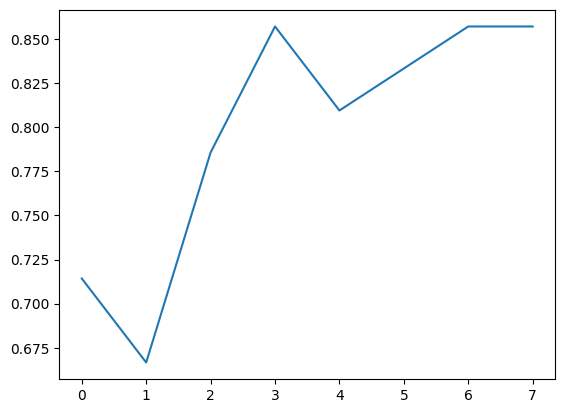

In [90]:
plt.plot(val_accuracies)